In [89]:
import multiprocessing

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from joblib import Parallel, delayed
import scipy as scp

plt.rc("font", family=["Helvetica", "Arial"])
plt.rc("text", usetex=True)
plt.rc("xtick", top=True, direction="in")
plt.rc("ytick", right=True, direction="in")

In [90]:
def generate_3_regular_graph(n: int) -> nx.Graph:
    """
    Generate a random 3-regular graph with n nodes.

    Args:
        n (int): Number of nodes in the graph. Must be an even number.

    Returns:
        nx.Graph: A NetworkX Graph object representing the 3-regular graph.

    Raises:
        ValueError: If the number of nodes is not even.
    """
    if n % 2 != 0:
        raise ValueError("The number of nodes must be even for a 3-regular graph.")

    G = nx.random_regular_graph(d=3, n=n)
    return G

def draw_graph(G: nx.Graph) -> None:
    """
    Draw the given graph using a spring layout.

    Args:
        G (nx.Graph): A NetworkX Graph object to be drawn.

    Returns:
        None
    """
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
    plt.show()

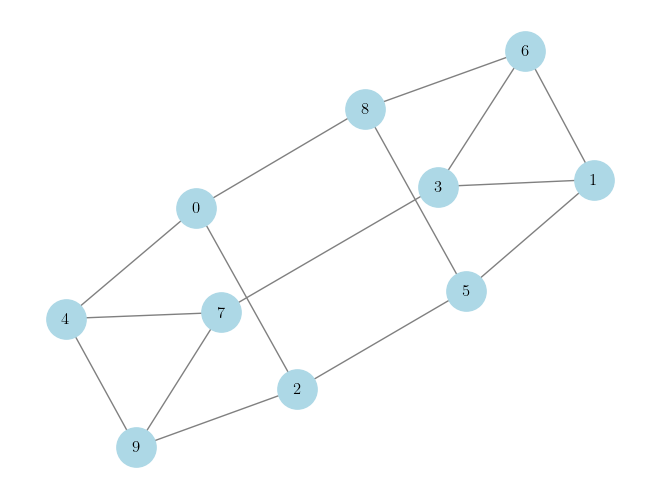

In [91]:
graph = generate_3_regular_graph(n=10)
draw_graph(graph)

In [92]:
def get_degree_constrained_subgraph(super_graph: nx.Graph, degree:int, probability: float) -> nx.Graph:
    _node_degree_counter = np.zeros(shape=(super_graph.number_of_nodes()))
    _sub_graph_edges = []
    for edge in list(super_graph.edges):
        if np.random.binomial(n=1,p=1-probability) == 1:
            node_i, node_j = edge
            _node_degree_counter[node_i] += 1
            _node_degree_counter[node_j] += 1
            _sub_graph_edges.append(edge)
            if _node_degree_counter[node_i] >= degree or _node_degree_counter[node_j] >= degree:
                _updated_sub_graph_edges = []
                for sub_edge in _sub_graph_edges:
                    sub_node_i, sub_node_j = sub_edge
                    if _node_degree_counter[sub_node_i] < degree and _node_degree_counter[sub_node_j] < degree:
                        _updated_sub_graph_edges.append(sub_edge)
                _sub_graph_edges = _updated_sub_graph_edges
    _subgraph = nx.Graph()
    _subgraph.add_edges_from(_sub_graph_edges)
    return _subgraph

In [93]:
def avg_relative_subgraph_sizes(probabilities, trials, min_graph_size, max_graph_size):
    _graph_sizes = np.arange(min_graph_size,max_graph_size,2)
    _avg_subgraph_sizes = []
    for i in range(len(probabilities)):
        _prob = probabilities[i]
        _temp = []
        for _graph_size in _graph_sizes:
            avg_nr_subgraph_edges_relative = 0
            for _trial in range(trials):
                _supergraph = generate_3_regular_graph(n=_graph_size)
                _subgraph   = get_degree_constrained_subgraph(super_graph=_supergraph,degree=2,probability=_prob)
                avg_nr_subgraph_edges_relative += _subgraph.number_of_edges() * 1.0/_supergraph.number_of_edges()
            avg_nr_subgraph_edges_relative *= 1.0/_trials
            _temp.append(avg_nr_subgraph_edges_relative)
        _avg_subgraph_sizes.append(np.mean(_temp))
    return _avg_subgraph_sizes

In [94]:
num_cores = multiprocessing.cpu_count()
print("Number of available CPU cores: ", num_cores)

Number of available CPU cores:  16


In [95]:
_pmin, _pmax = 0.001,0.999
_n_probs = 1000
_probabilities = np.linspace(_pmin,_pmax,_n_probs)

_trials = 400
_min_graph_size, _max_graph_size = 4, 50

########################################################################################
######## Partitioning into even sized intervals -> One interval pr. core in CPU ########
########################################################################################
# Calculate the range_size that is a multiple of num_cores
_N_max = _n_probs
range_size = ((_N_max-1) // num_cores) * num_cores
# Adjust N_max value
N_max_adjusted = 1 + range_size
# Calculate interval size
Interval_size = int((N_max_adjusted - 1) / num_cores)
# Calculate partitions
partitions = [_probabilities[Interval_size * i: Interval_size * (i+1)] for i in range(num_cores)]
print(f"Adjusted N_max from {_N_max} to {N_max_adjusted} and now have {num_cores} evenly sized intervals of size {Interval_size}.")


Adjusted N_max from 1000 to 993 and now have 16 evenly sized intervals of size 62.


In [96]:
backend = 'loky'
results = Parallel(n_jobs=num_cores, backend=backend)(delayed(avg_relative_subgraph_sizes)(partition,_trials,_min_graph_size,_max_graph_size) for partition in partitions)

In [97]:
avg_relative_sizes = []
for result in results:
    avg_relative_sizes += result
probabilities = []
for probability in partitions:
    probabilities += probability.tolist()

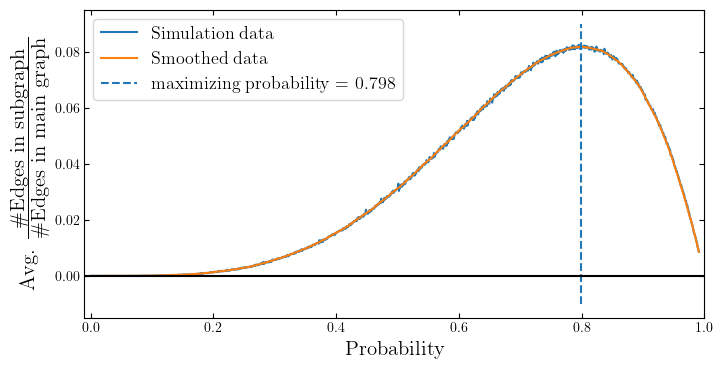

In [102]:
fig, ax = plt.subplots(1,1,figsize=(8,4))

ax.plot(probabilities,avg_relative_sizes, label="Simulation data")

smooth_y = scp.signal.savgol_filter(x=avg_relative_sizes,window_length=30,polyorder=3)
ax.plot(probabilities,smooth_y, label="Smoothed data")

max_prop = probabilities[np.argmax(smooth_y)]
ax.vlines(max_prop,-0.01,1.1*np.max(smooth_y),ls='--',label=f'maximizing probability = {np.round(max_prop,3)}')

ax.set_ylabel(r'Avg. $\frac{\textrm{\#Edges in subgraph}}{\textrm{\#Edges in main graph}}$', size=15)
ax.set_xlabel('Probability', size=15)
ax.hlines(0,-0.01,1,color='k')
ax.set_xlim(-0.01,1)
ax.legend(fontsize=13)
plt.show()